In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

In [2]:
data = pd.read_csv("../data/conversion_data.csv")
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
for col in data.columns:
    print("Column: ", col)
    print(data[col].value_counts())
    print()

Column:  country
US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

Column:  age
30     14346
28     14341
29     14158
27     14084
26     13931
31     13692
32     13507
25     13460
24     12960
33     12631
23     12336
34     12108
22     11701
35     11471
21     10966
36     10779
20     10156
37      9761
19      9349
38      8970
18      8466
39      8202
17      7597
40      7148
41      6401
42      5588
43      4904
44      4224
45      3634
46      2994
47      2504
48      2121
49      1629
50      1356
51      1093
52       935
53       627
54       520
55       394
56       286
57       247
58       165
59       127
60        94
61        71
62        59
63        35
64        27
65        15
66         9
67         5
68         5
69         3
70         2
77         1
79         1
111        1
73         1
72         1
123        1
Name: age, dtype: int64

Column:  new_user
1    216744
0     99456
Name: new_user, dtype:

There are no missing data. We have users with age > 100, which looks unrealistic.\
There are only two such users, so removing those rows should not be a problem.

In [5]:
data = data[data["age"] < 100]

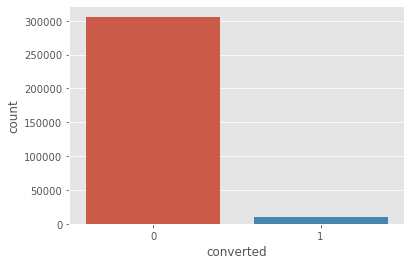

In [6]:
sns.countplot(x="converted", data=data);

In [7]:
data["converted"].value_counts(normalize=True)*100

0    96.774806
1     3.225194
Name: converted, dtype: float64

Baseline conversion rate is roughly 3.2%.

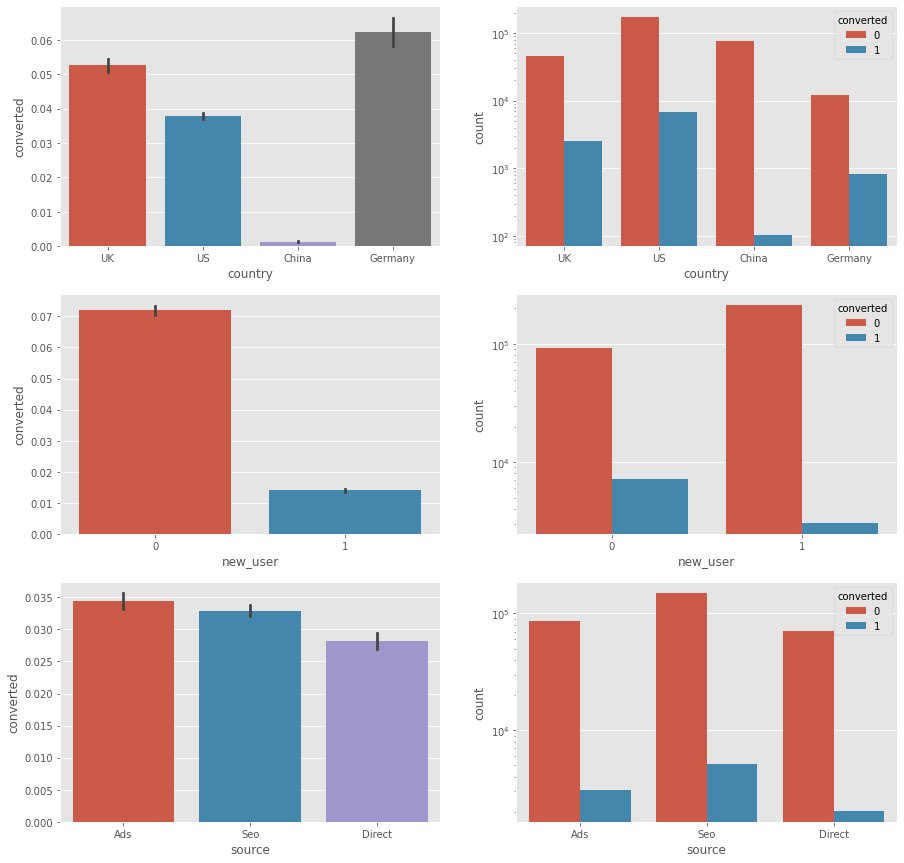

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))
sns.barplot(x="country", y="converted", data=data, ax=axes[0, 0])
sns.countplot(x="country", hue="converted", data=data, ax=axes[0, 1])
axes[0, 1].set_yscale('log')

sns.barplot(x="new_user", y="converted", data=data, ax=axes[1, 0])
sns.countplot(x="new_user", hue="converted", data=data, ax=axes[1, 1])
axes[1, 1].set_yscale('log')

sns.barplot(x="source", y="converted", data=data, ax=axes[2, 0])
sns.countplot(x="source", hue="converted", data=data, ax=axes[2, 1])
axes[2, 1].set_yscale('log')

1. Users from China are unlikely to convert.
2. New users in general are unlikely to convert.
3. Conversion rates across different marketing channels are similar.

In [9]:
conv_by_country = data.groupby(['country', 'converted']).agg({'age': 'count'})
country_total = data.groupby(['country']).agg({'age': 'count'})
conv_by_country.div(country_total, level='country') * 100

age
country converted           
China   0          99.866844
        1           0.133156
Germany 0          93.757181
        1           6.242819
UK      0          94.738797
        1           5.261203
US      0          96.219931
        1           3.780069

In [10]:
print("Conversion (Old Users): ")
print(data[data["new_user"] == 0]["converted"].value_counts(normalize=True)*100)
print()
print("Conversion (New Users): ")
print(data[data["new_user"] == 1]["converted"].value_counts(normalize=True)*100)

Conversion (Old Users): 
0    92.801697
1     7.198303
Name: converted, dtype: float64

Conversion (New Users): 
0    98.597885
1     1.402115
Name: converted, dtype: float64


In [11]:
conv_by_source = data.groupby(["source", "converted"]).agg({"source": "count"})
source_total = data.groupby("source").agg({"source": "count"})
conv_by_source.div(source_total, level="source") * 100

source
source converted           
Ads    0          96.552812
       1           3.447188
Direct 0          97.183099
       1           2.816901
Seo    0          96.711150
       1           3.288850

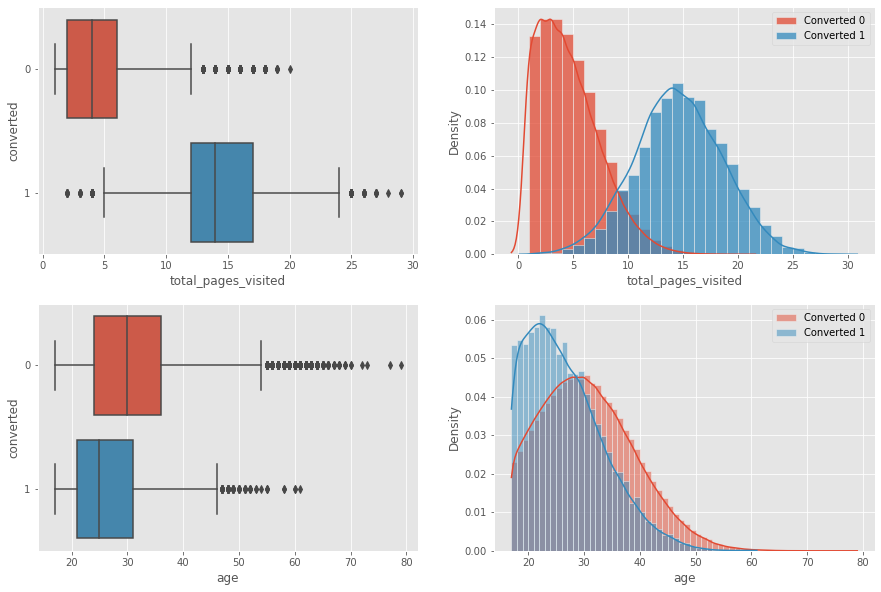

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.boxplot(x="total_pages_visited", y="converted", data=data, orient="h", ax=axes[0, 0])
sns.histplot(x="total_pages_visited", data=data[data["converted"] == 0], binwidth=1, stat="density", ax=axes[0, 1], color=sns.color_palette()[0], label="Converted 0")
sns.kdeplot(x="total_pages_visited", data=data[data["converted"] == 0], bw_adjust=2.4, ax=axes[0, 1], color=sns.color_palette()[0])
sns.histplot(x="total_pages_visited", data=data[data["converted"] == 1], binwidth=1, stat="density", ax=axes[0, 1], label="Converted 1")
sns.kdeplot(x="total_pages_visited", data=data[data["converted"] == 1], ax=axes[0, 1], color=sns.color_palette()[1])
axes[0, 1].legend()

sns.boxplot(x="age", y="converted", data=data, orient="h", ax=axes[1, 0])
sns.histplot(x="age", data=data[data["converted"] == 0], kde=True, binwidth=1, stat="density", ax=axes[1, 1], color=sns.color_palette()[0], label="Converted 0")
sns.histplot(x="age", data=data[data["converted"] == 1], kde=True, binwidth=1, stat="density", ax=axes[1, 1], label="Converted 1")
axes[1, 1].legend();

1. Converted users visit more pages.
2. Younger people are more likely to convert.

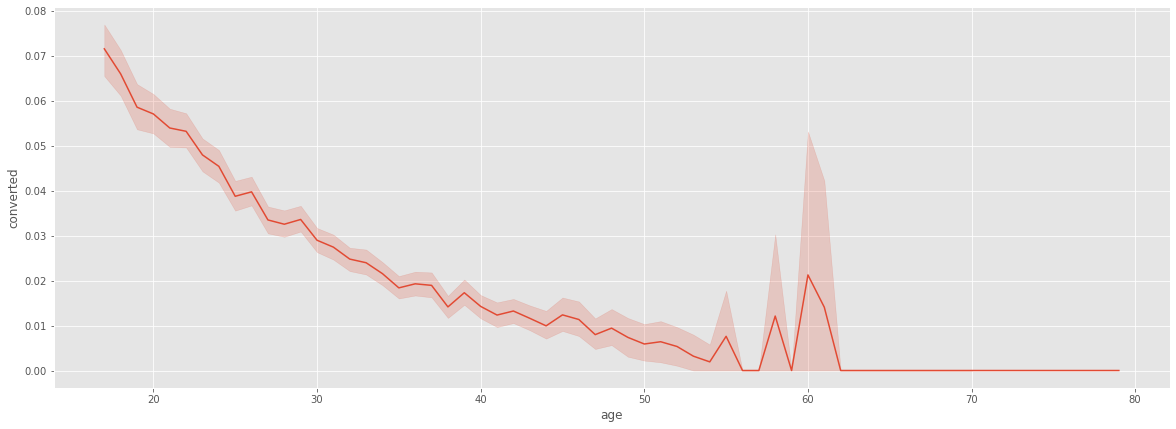

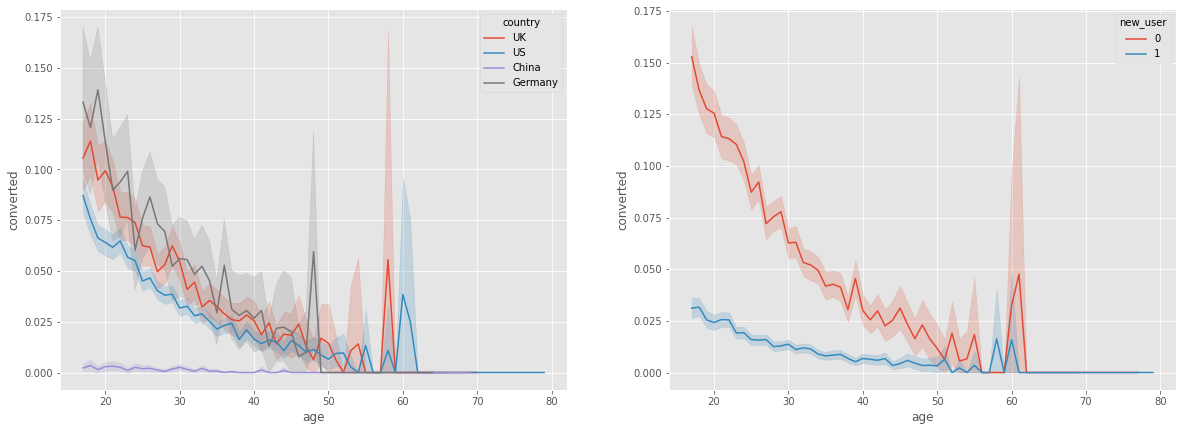

In [13]:
fig, axes = plt.subplots(figsize=(20, 7))
sns.lineplot(x="age", y="converted", data=data)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.lineplot(x="age", y="converted", hue="country", data=data, ax=axes[0])
sns.lineplot(x="age", y="converted", hue="new_user", data=data, ax=axes[1]);

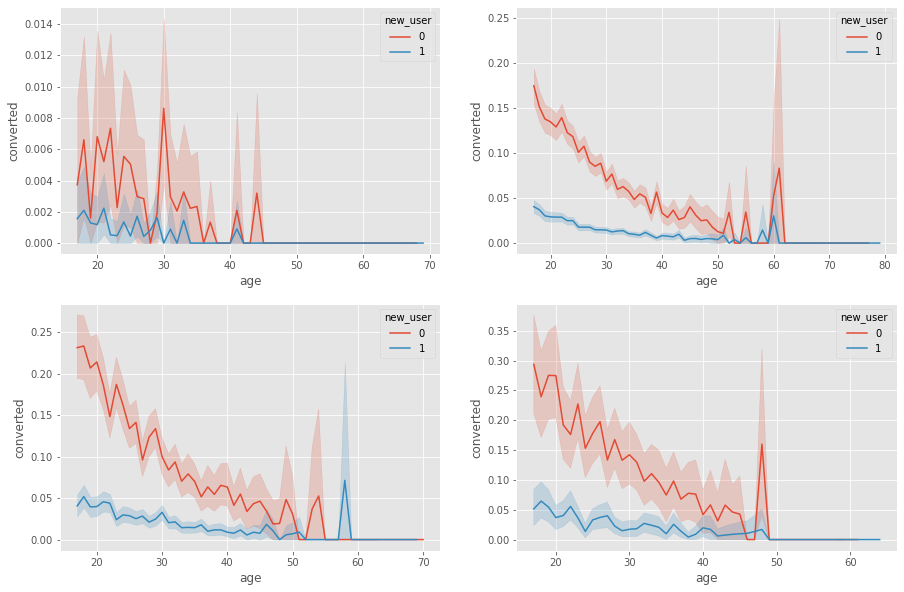

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.lineplot(x="age", y="converted", hue="new_user", data=data[data["country"] == "China"], ax=axes[0, 0])
sns.lineplot(x="age", y="converted", hue="new_user", data=data[data["country"] == "US"], ax=axes[0, 1])
sns.lineplot(x="age", y="converted", hue="new_user", data=data[data["country"] == "UK"], ax=axes[1, 0])
sns.lineplot(x="age", y="converted", hue="new_user", data=data[data["country"] == "Germany"], ax=axes[1, 1]);

1. The older the users are, the less likely they convert, on average.
2. The difference in conversion rates across age groups is more prominent for the returning users than for the new users.
3. Conversion rates for the Chinese people across different age groups don't have the same trend as in the US, UK and Germany.
4. Interestingly, users aged around 60 years convert more than we would expect from following the age trend.

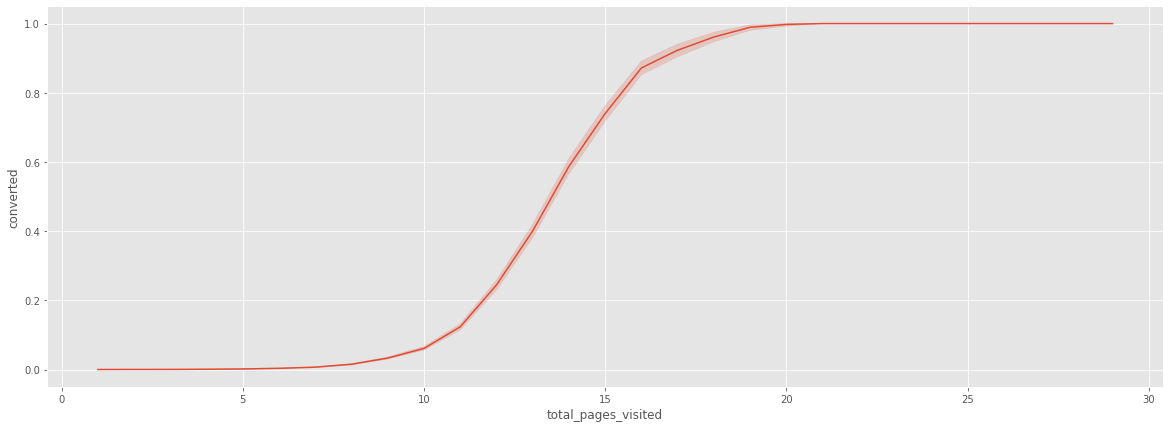

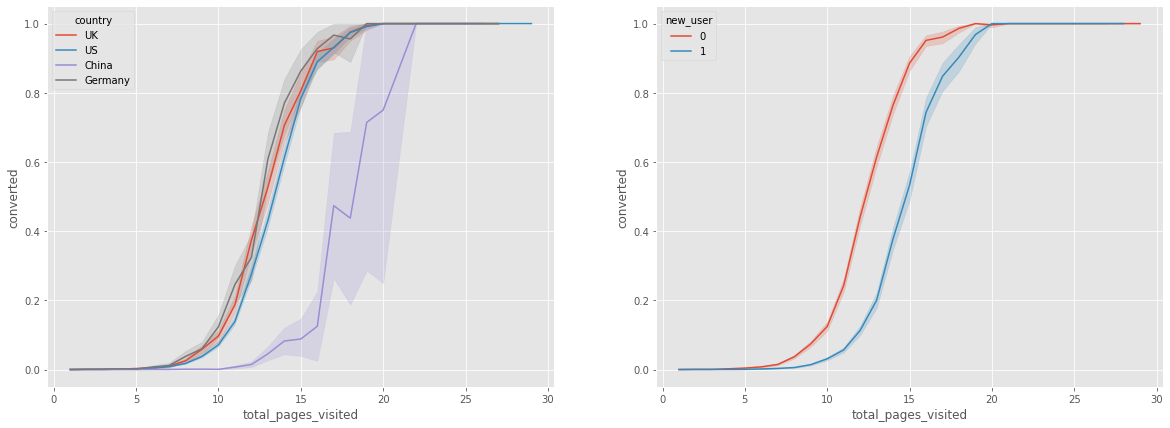

In [15]:
fig, axes = plt.subplots(figsize=(20, 7))
sns.lineplot(x="total_pages_visited", y="converted", data=data)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.lineplot(x="total_pages_visited", y="converted", hue="country", data=data, ax=axes[0])
sns.lineplot(x="total_pages_visited", y="converted", hue="new_user", data=data, ax=axes[1]);

1. The more pages users visit, the more likely it is that they converted.
2. For the same number of visited pages, the probability of conversion for the Chinese people is noticeably less than for American, British and German people.
3. Having visited the same number of pages, the probability that the new users convert is less than that for the returning users.

## Machine Learning

In [16]:
data["converted"].value_counts(normalize=True)*100

0    96.774806
1     3.225194
Name: converted, dtype: float64

The data is highly imbalanced, so we need to keep that in mind when building a predictive model.

In [17]:
numeric_features = ["age", "total_pages_visited"]
num_transformer = Pipeline(steps=[
    ('power', PowerTransformer())
])

categorical_features = ["country", "source"]
cat_transformer = Pipeline(steps=[
    ("dummy", OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, numeric_features),
    ("cat", cat_transformer, categorical_features)
], remainder="passthrough")

In [18]:
X, y = data.drop("converted", axis=1), data["converted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, stratify=y)

In [19]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

In [20]:
rfc_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("rfc", RandomForestClassifier(n_estimators=200, class_weight={0: 0.7, 1: 0.3}))
])
scores = cross_val_score(rfc_pipe, X_train, y_train, scoring="roc_auc", cv=cv)
print("Random Forest Classifier")
print("ROC AUC: ", scores.mean())

Random Forest Classifier
ROC AUC:  0.9514579237707735


In [21]:
lr_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lr", LogisticRegression())
])
scores = cross_val_score(lr_pipe, X_train, y_train, scoring="roc_auc", cv=cv)
print("Logistic Regression")
print("ROC AUC: ", scores.mean())

Logistic Regression
ROC AUC:  0.9852431821654176


In [22]:
knn_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("knn", KNeighborsClassifier())
])
scores = cross_val_score(knn_pipe, X_train, y_train, scoring="roc_auc", cv=cv)
print("K-Nearest Neighbors Classifier")
print("ROC AUC: ", scores.mean())

K-Nearest Neighbors Classifier
ROC AUC:  0.91875905201428


Logistic regression model has the highest cross-validation accuracy score of 98.5%.

In [23]:
models = [{
        'label': 'Random Forest',
        'model': rfc_pipe,
    }, {
        'label': 'Logistic Regression',
        'model': lr_pipe,
    }, {
        'label': 'KNN',
        'model': knn_pipe,
    }
]

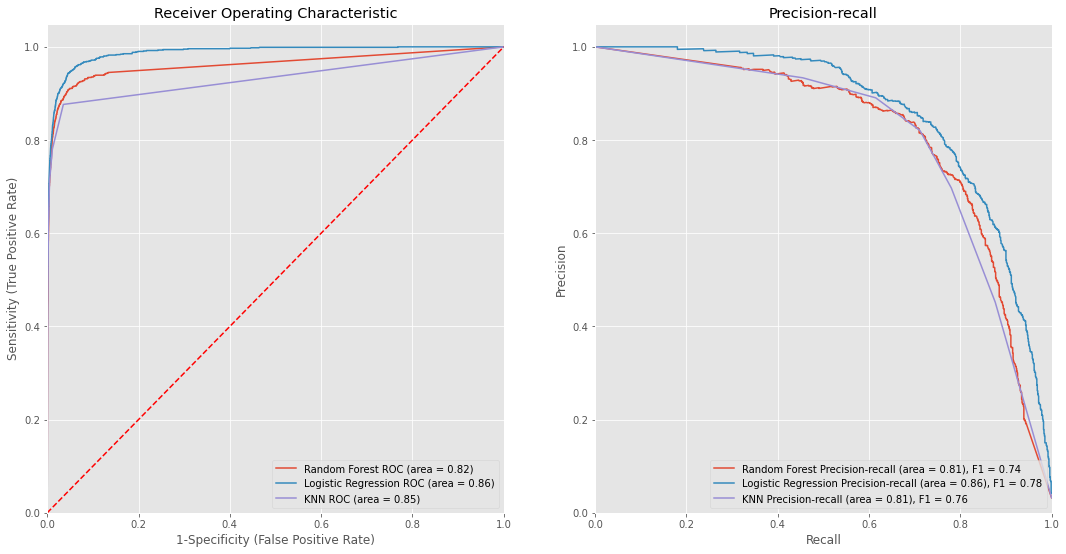

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

for m in models:
    model = m['model'] 
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    # ROC
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    auc_score = roc_auc_score(y_test,model.predict(X_test))
    ax1.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc_score))
    
    # Precision-recall
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
    auc_score = auc(recall, precision)
    f1 = f1_score(y_test, y_pred)
    ax2.plot(recall, precision, label='%s Precision-recall (area = %0.2f), F1 = %0.2f' % (m['label'], auc_score, f1))
    
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('1-Specificity (False Positive Rate)')
ax1.set_ylabel('Sensitivity (True Positive Rate)')
ax1.set_title('Receiver Operating Characteristic')
ax1.legend(loc="lower right")

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-recall')
ax2.legend(loc="lower right")

Logistic regression model has the best performance when applied to the test set, so we'll use it to get feature importances.

In [25]:
def transform_data(data, num_features):
    transformed = pd.get_dummies(data)
    pt = PowerTransformer()
    transformed[num_features] = pt.fit_transform(transformed[num_features])
    return transformed

In [26]:
X_train_transformed = transform_data(X_train, ["age", "total_pages_visited"])

In [27]:
lr = LogisticRegression()
lr.fit(X_train_transformed, y_train)

LogisticRegression()

In [28]:
importances = lr.coef_[0]

In [29]:
imp_df = pd.DataFrame(zip(X_train_transformed.columns, importances), columns=["Feature", "Score"]).sort_values(by="Score", key=abs, ascending=False)
imp_df

,Feature,Score
2,total_pages_visited,4.661473
3,country_China,-2.541033
1,new_user,-1.663505
4,country_Germany,1.097947
5,country_UK,0.895851
0,age,-0.548432
6,country_US,0.543272
8,source_Direct,-0.112919
7,source_Ads,0.060874
9,source_Seo,0.048081


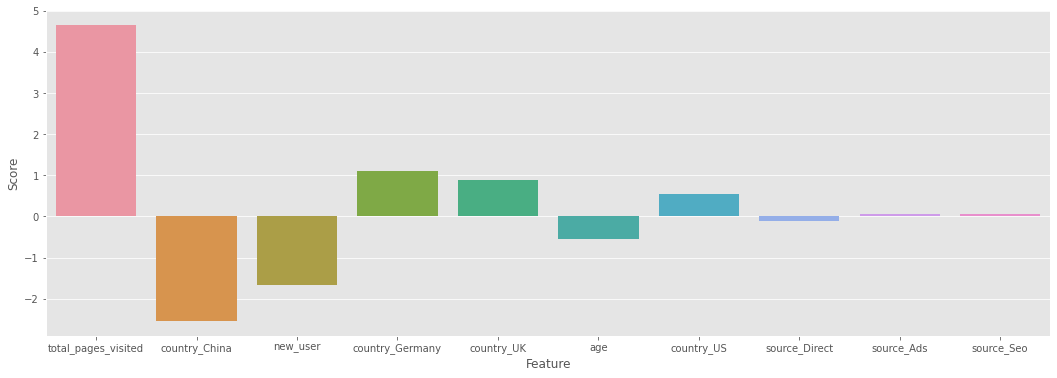

In [30]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x="Feature", y="Score", data=imp_df);

1. The most important feature is **total_pages_visited**. However, we need to be careful with this metric, as visiting more pages doesn't cause users to convert. Converted users just visit more pages as a result of their actions - buying products in this case.
2. The second important feature is **country_China** (whether a user is from China). We can investigate why the Chinese people are less inclined to buy products, and based on that investigation, we can make improvements to the site. We should also look into why the Chinese people are unlikely to be converted users compared to the other countries, when they visit the same number of pages.
3. The next important feature is **new_user** (whether a user is new to the site). Somehow the new users across all countries and age groups don't convert as much as their returning peers. Improving the site to provide better experience for new users will help increase the conversion rate.